<a href="https://colab.research.google.com/github/Pisarenkova/KT_2025/blob/main/deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install deepxde

Compiling model...
Building feed-forward neural network...
'build' took 0.057070 s

'compile' took 0.632725 s

Training model...

0         [2.50e+01, 1.31e+00]    [2.50e+01, 1.31e+00]    [2.32e+00]    
1000      [2.91e-03, 8.17e-04]    [2.91e-03, 8.17e-04]    [3.32e-02]    

Best model at step 1000:
  train loss: 3.73e-03
  test loss: 3.73e-03
  test metric: [3.32e-02]

'train' took 5.484721 s

Training model...

Step      Train loss              Test loss               Test metric   
1000      [2.91e-03, 8.17e-04]    [2.91e-03, 8.17e-04]    [3.32e-02]    
2000      [1.34e-02, 2.30e-04]    [1.34e-02, 2.30e-04]    [2.71e-02]    

Best model at step 1000:
  train loss: 3.73e-03
  test loss: 3.73e-03
  test metric: [3.32e-02]

'train' took 2.573687 s

Training model...

Step      Train loss              Test loss               Test metric   
2000      [1.34e-02, 2.30e-04]    [1.34e-02, 2.30e-04]    [2.71e-02]    
3000      [5.04e-04, 1.38e-04]    [5.04e-04, 1.38e-04]    [1.25e-02]    

B

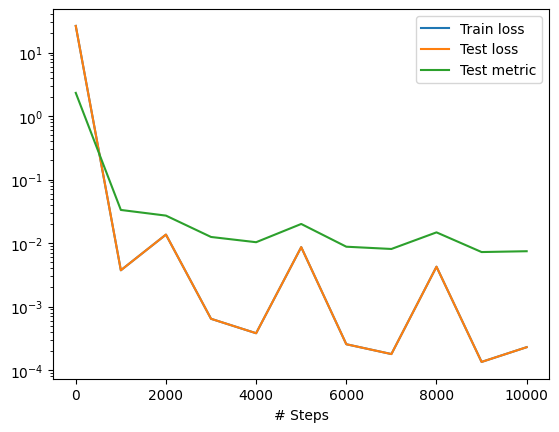

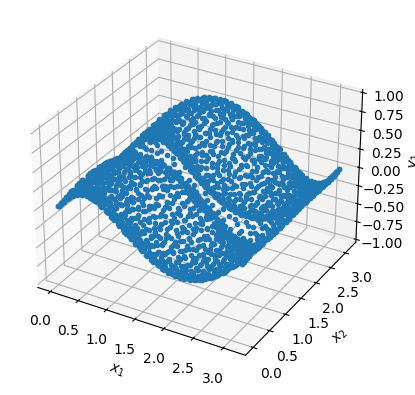

In [80]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf
import matplotlib.animation as animation

def domain():
    return dde.geometry.Rectangle(xmin=[0, 0], xmax=[np.pi, np.pi])

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    return -dy_xx - dy_yy - f(x)

def boundary(x, on_boundary):
    return on_boundary

k = 1
l = 3

def exact_solution(x):
    return np.sin(k * x[:, 0:1]) * np.cos(l*x[:, 1:2])

def f(x):
    return (k**2+l**2) * tf.sin(k * x[:, 0:1]) * tf.cos(l*x[:, 1:2])

def g(x):
    return exact_solution(x).reshape(-1, 1)

geom = domain()
bc = dde.icbc.DirichletBC(geom, g, boundary)
data = dde.data.PDE(geom, pde, bc, num_domain=2000, num_boundary=200, solution=g)

layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

predictions = []

model.compile("adam", lr=0.001, metrics=["l2 relative error"])

for i in range(10):
    losshistory, train_state = model.train(iterations=1000)
    x = geom.uniform_points(2500, True)
    y_pred = model.predict(x)
    predictions.append(y_pred)

#losshistory, train_state = model.train(iterations=6000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

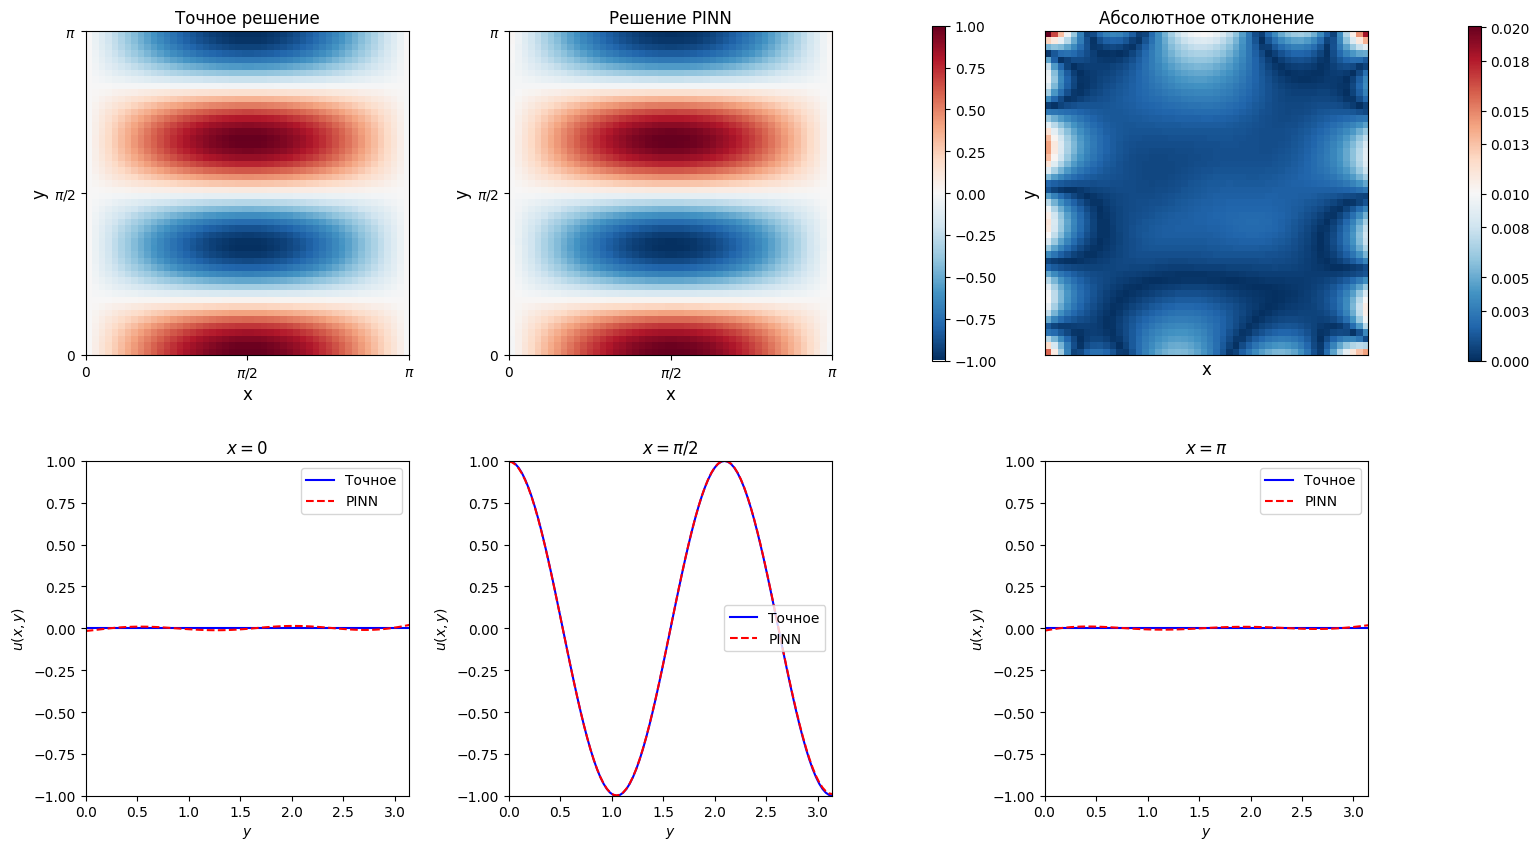

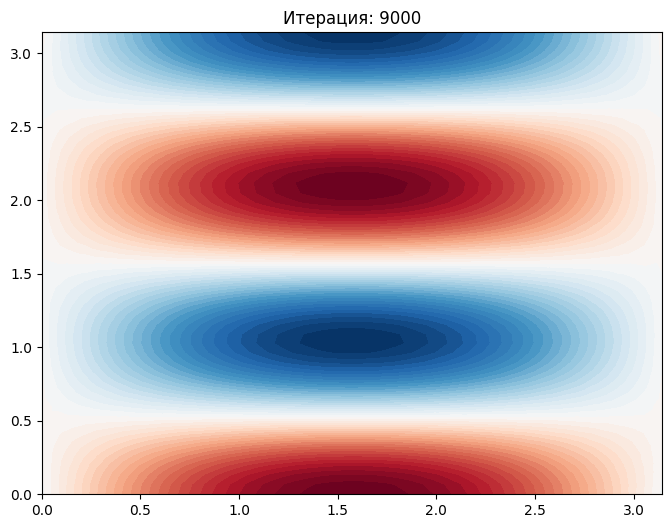

In [84]:
from matplotlib import colors
import matplotlib.gridspec as gridspec

def visualize_solution(model):
    x = geom.uniform_points(2500, True)
    y_exact = g(x)

    h_min, h_max, v_min, v_max = 0, np.pi, 0, np.pi

    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 5, height_ratios=[1, 1], width_ratios=[1, 1, 0.04, 1, 0.04], wspace=0.5, hspace=0.3)

    titles = ["Точное решение", "Решение PINN", "Абсолютное отклонение"]
    data = [y_exact.reshape(50,50, order='F'), predictions[-1].reshape(50,50, order='F'), np.abs(y_exact - predictions[-1]).reshape(50,50, order='F')]

    def create_subplot(ax, data, title):
        c = ax.imshow(data, extent=(h_min, h_max, v_min, v_max), origin='lower', cmap='RdBu_r')
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_xticks([0, np.pi/2, np.pi])
        ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$'])
        ax.set_yticks([0, np.pi/2, np.pi])
        ax.set_yticklabels(['$0$', '$\pi/2$', '$\pi$'])
        if title == "Абсолютное отклонение":
          ax.set_xticks([])
          ax.set_yticks([])
        return c

    c1 = create_subplot(fig.add_subplot(gs[0, 0]), data[0],titles[0])

    c4 = create_subplot(fig.add_subplot(gs[0, 3]), data[2],titles[2])

    c2 = create_subplot(fig.add_subplot(gs[0, 1]), data[1],titles[1])


    norm = colors.Normalize(vmin=np.min(data[0:1]), vmax=np.max(data[0:1]))
    cbar = fig.colorbar(c2, cax=fig.add_subplot(gs[0, 2]), norm=norm)
    cbar.set_ticks(np.linspace(np.min(data[0:1]), np.max(data[0:1]), 9).round(2))

    def add_colorbar(c, ax, data):
      norm = plt.Normalize(np.min(data), np.max(data))
      cbar = fig.colorbar(c, cax=ax, norm=norm)
      cbar.set_ticks(np.linspace(np.min(data), np.max(data), 9).round(3))

    add_colorbar(c4, fig.add_subplot(gs[0, 4]), data[2])

    x_values = [0, np.pi/2, np.pi]
    y_slice = np.linspace(0, np.pi, 100)

    A = ['0', '\pi/2', '\pi']

    #plt.figure(figsize=(12, 4))

    for i, t in enumerate(x_values):
      x_test = np.column_stack((np.full_like(y_slice, t), y_slice))
      y_exact = exact_solution(x_test).flatten()
      y_pred = model.predict(x_test).flatten()

      if i == 2:
        c_ax = fig.add_subplot(gs[1, i+1])
      else:
        c_ax = fig.add_subplot(gs[1, i])

      c_ax.plot(y_slice, y_exact, 'b-', label="Точное")
      c_ax.plot(y_slice, y_pred, 'r--', label="PINN")
      c_ax.set_xlabel(r"$y$")
      c_ax.set_ylabel(r"$u(x, y)$")
      c_ax.set_title(f'$x = {A[i]}$')
      c_ax.set_xlim(0, np.pi)
      c_ax.set_ylim(-1,1)
      c_ax.legend()

    #plt.tight_layout()
    plt.show()

def animate_solution(predictions):
    fig, ax = plt.subplots(figsize=(8, 6))
    x = geom.uniform_points(2500, True)

    def update(frame):
        ax.clear()
        ax.tricontourf(x[:, 0], x[:, 1], predictions[frame].flatten(), levels=50, cmap="RdBu_r")
        ax.set_title(f"Итерация: {frame * 1000}")

    ani = animation.FuncAnimation(fig, update, frames=len(predictions), repeat=False)
    ani.save('solution_animation.mp4', writer='ffmpeg', fps=2)

visualize_solution(model)
animate_solution(predictions)